<a href="https://colab.research.google.com/github/TheDoctorAI/AI-Trader/blob/master/bayesian_evolution_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
!pip install ccxt pprint
# -*- coding: utf-8 -*-
import ccxt
from datetime import datetime
import csv
from google.colab import drive
from pprint import pprint
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
def write_to_csv(filename, data):
    with open(filename, mode='w') as output_file:
        output_file.write("Date,Open,High,Low,Close,Adj Close,Volume\n")
        csv_writer = csv.writer(output_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerows(data)

        
def scrape_ohlcv(exchange, max_retries, symbol, timeframe, since, limit):
    earliest_timestamp = exchange.milliseconds()
    timeframe_duration_in_seconds = exchange.parse_timeframe(timeframe)
    timeframe_duration_in_ms = timeframe_duration_in_seconds * 1000
    timedelta = limit * timeframe_duration_in_ms
    all_ohlcv = []
    while True:
        fetch_since = earliest_timestamp - timedelta
        ohlcv = retry_fetch_ohlcv(exchange, max_retries, symbol, timeframe, fetch_since, limit)
        if ohlcv[0][0] >= earliest_timestamp:
            break
        earliest_timestamp = ohlcv[0][0]
        all_ohlcv = ohlcv + all_ohlcv
        print(len(all_ohlcv), 'candles in total from', exchange.iso8601(all_ohlcv[0][0]), 'to', exchange.iso8601(all_ohlcv[-1][0]))
        if fetch_since < since:
            break
    return all_ohlcv


def retry_fetch_ohlcv(exchange, max_retries, symbol, timeframe, since, limit):
    num_retries = 0
    try:
        num_retries += 1
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since)
        return ohlcv
    except Exception:
        if num_retries > max_retries:
            raise

            
def scrape_candles_to_csv(filename, exchange_id, max_retries, symbol, timeframe, since, limit):
    exchange = getattr(ccxt, exchange_id)({
        'enableRateLimit': True,
    })
    if isinstance(since, str):
        since = exchange.parse8601(since)
    exchange.load_markets()
    ohlcv = scrape_ohlcv(exchange, max_retries, symbol, timeframe, since, limit)
    key = 0
    for candle in ohlcv:
        epoch = int(candle[0]) / 1000
        ohlcv[key][0] = datetime.utcfromtimestamp(epoch).strftime('%Y-%m-%d')
        ohlcv[key][5] = int(candle[5])
        ohlcv[key].append(ohlcv[key][5])
        ohlcv[key][5] = ohlcv[key][4]
        key += 1
    ohlen = len(ohlcv)
    pprint("num of candles: "+ str(ohlen))
    if ohlen > 399:
        ohrem = ohlen - 399
        pprint("removing: "+str(ohrem))
        ohlcv = ohlcv[ohrem:]
    write_to_csv(filename, ohlcv)
    print('Saved', len(ohlcv), 'candles from', exchange.iso8601(ohlcv[0][0]), 'to', exchange.iso8601(ohlcv[-1][0]), 'to', filename)

In [41]:
exchange = "bitmex"
symbol = "BTC/USD"
start_date = "2018-01-01T00:00:00Z"

timeframe = "1d"
outfile = "/content/gdrive/My Drive/Colab Notebooks/ai-trader/data/btcusd-"+timeframe+".csv"
scrape_candles_to_csv(outfile, exchange, 3, symbol, timeframe, start_date, 100)

100 candles in total from 2019-01-30T00:00:00.000Z to 2019-05-09T00:00:00.000Z
200 candles in total from 2018-10-22T00:00:00.000Z to 2019-05-09T00:00:00.000Z
300 candles in total from 2018-07-14T00:00:00.000Z to 2019-05-09T00:00:00.000Z
400 candles in total from 2018-04-05T00:00:00.000Z to 2019-05-09T00:00:00.000Z
500 candles in total from 2017-12-26T00:00:00.000Z to 2019-05-09T00:00:00.000Z
'num of candles: 500'
'removing: 101'
Saved 399 candles from None to None to /content/gdrive/My Drive/Colab Notebooks/ai-trader/data/btcusd-1d.csv


In [42]:
!pip install bayesian-optimization==0.6

In [0]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
from bayes_opt import BayesianOptimization
sns.set()

In [44]:
import pkg_resources
import types

def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split('.')[0]
        elif isinstance(val, type):
            name = val.__module__.split('.')[0]
        poorly_named_packages = {'PIL': 'Pillow', 'sklearn': 'scikit-learn'}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name


imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != 'pip':
        requirements.append((m.project_name, m.version))

for r in requirements:
    print('{}=={}'.format(*r))

seaborn==0.9.0
pandas==0.24.2
numpy==1.16.3
matplotlib==3.0.3
google==2.0.2


In [0]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[0 : t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

TSLA Time Period: **Mar 23, 2018 - Mar 23, 2019**

In [46]:
df = pd.read_csv(outfile)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-04-06,6779.0,6935.0,6555.0,6769.5,6769.5,3283289247
1,2018-04-07,6769.5,6875.0,6479.5,6612.0,6612.0,2256699483
2,2018-04-08,6612.0,7058.5,6608.0,6900.5,6900.5,1935569407
3,2018-04-09,6900.5,7137.0,6885.0,7014.0,7014.0,1602230571
4,2018-04-10,7014.0,7177.5,6600.0,6763.0,6763.0,2772773920


In [0]:
close = df.Close.values.tolist()
window_size = 30
skip = 5
l = len(close) - 1

In [0]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [0]:
class Agent:
    def __init__(
        self,
        population_size,
        sigma,
        learning_rate,
        model,
        money,
        max_buy,
        max_sell,
        skip,
        window_size,
    ):
        self.window_size = window_size
        self.skip = skip
        self.POPULATION_SIZE = population_size
        self.SIGMA = sigma
        self.LEARNING_RATE = learning_rate
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = get_state(close, 0, self.window_size + 1)
        inventory = []
        quantity = 0
        for t in range(0, l, self.skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell

            state = next_state
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = get_state(close, 0, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(0, l, self.skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (t, sell_units, total_sell, invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        print(
            '\ntotal gained %f, total investment %f %%'
            % (initial_money - starting_money, invest)
        )
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.show()

In [0]:
def best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    model = Model(window_size, size_network, 3)
    agent = Agent(
        population_size,
        sigma,
        learning_rate,
        model,
        10000,
        5,
        5,
        skip,
        window_size,
    )
    try:
        agent.fit(100, 1000)
        return agent.es.reward_function(agent.es.weights)
    except:
        return 0

In [0]:
def find_best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    global accbest
    param = {
        'window_size': int(np.around(window_size)),
        'skip': int(np.around(skip)),
        'population_size': int(np.around(population_size)),
        'sigma': max(min(sigma, 1), 0.0001),
        'learning_rate': max(min(learning_rate, 0.5), 0.000001),
        'size_network': int(np.around(size_network)),
    }
    print('\nSearch parameters %s' % (param))
    investment = best_agent(**param)
    print('stop after 100 iteration with investment %f' % (investment))
    if investment > accbest:
        costbest = investment
    return investment

In [33]:
accbest = 0.0
NN_BAYESIAN = BayesianOptimization(
    find_best_agent,
    {
        'window_size': (2, 50),
        'skip': (1, 15),
        'population_size': (1, 50),
        'sigma': (0.01, 0.99),
        'learning_rate': (0.000001, 0.49),
        'size_network': (10, 1000),
    },
)
NN_BAYESIAN.maximize(init_points = 30, n_iter = 50, acq = 'ei', xi = 0.0)

time taken to train: 31.356859922409058 seconds
stop after 100 iteration with investment 316.865000
    4 | 00m31s |  316.86500 |          0.2219 |           43.5569 |    0.8611 |       905.0214 |    4.3266 |       36.4940 | 

Search parameters {'window_size': 43, 'skip': 10, 'population_size': 7, 'sigma': 0.6897619549143145, 'learning_rate': 0.3028881793863592, 'size_network': 200}
time taken to train: 1.221968412399292 seconds
stop after 100 iteration with investment 450.190000
    5 | 00m01s |  450.19000 |          0.3029 |            7.2112 |    0.6898 |       200.4306 |   10.0114 |       42.8011 | 

Search parameters {'window_size': 14, 'skip': 4, 'population_size': 23, 'sigma': 0.11489485013273214, 'learning_rate': 0.2934333456855358, 'size_network': 711}
time taken to train: 9.114705085754395 seconds
stop after 100 iteration with investment -82.205000
    6 | 00m09s |  -82.20500 |          0.2934 |           22.9498 |    0.1149 |       711.2003 |    4.0281 |       13.5934 | 

Se

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


stop after 100 iteration with investment 0.000000
   33 | 00m02s |    0.00000 |          0.0945 |           24.1172 |    0.0149 |       671.4611 |    3.5393 |       33.1989 | 

Search parameters {'window_size': 31, 'skip': 2, 'population_size': 37, 'sigma': 0.5448260570652482, 'learning_rate': 0.43243040817194417, 'size_network': 336}
time taken to train: 27.761034727096558 seconds
stop after 100 iteration with investment 877.145000
   34 | 00m28s |  877.14500 |          0.4324 |           36.7791 |    0.5448 |       336.1402 |    2.2727 |       30.7709 | 

Search parameters {'window_size': 33, 'skip': 2, 'population_size': 35, 'sigma': 0.5247716356997567, 'learning_rate': 0.42306653808028977, 'size_network': 338}
time taken to train: 27.549167156219482 seconds
stop after 100 iteration with investment 782.620000
   35 | 00m28s |  782.62000 |          0.4231 |           35.1092 |    0.5248 |       337.6842 |    1.7934 |       32.8061 | 

Search parameters {'window_size': 48, 'skip': 8, 

/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00180656]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 2, 'warnflag': 2}
  ConvergenceWarning)



Search parameters {'window_size': 20, 'skip': 4, 'population_size': 30, 'sigma': 0.9084554526160861, 'learning_rate': 0.14256939423746778, 'size_network': 764}
time taken to train: 14.01869249343872 seconds
stop after 100 iteration with investment 146.515000
   50 | 00m15s |  146.51500 |          0.1426 |           29.5680 |    0.9085 |       764.2717 |    3.9956 |       20.4016 | 

Search parameters {'window_size': 31, 'skip': 7, 'population_size': 14, 'sigma': 0.7195496714417147, 'learning_rate': 0.12675041755118385, 'size_network': 796}
time taken to train: 6.197476863861084 seconds
stop after 100 iteration with investment 369.480000
   51 | 00m07s |  369.48000 |          0.1268 |           14.2174 |    0.7195 |       795.6516 |    7.1121 |       31.2228 | 

Search parameters {'window_size': 49, 'skip': 5, 'population_size': 17, 'sigma': 0.661880498426195, 'learning_rate': 0.4356803627185784, 'size_network': 273}
time taken to train: 7.5066399574279785 seconds
stop after 100 iterat

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


stop after 100 iteration with investment 0.000000
   54 | 00m07s |    0.00000 |          0.0561 |           16.7077 |    0.1325 |       994.1507 |   12.1086 |       41.4960 | 

Search parameters {'window_size': 15, 'skip': 10, 'population_size': 10, 'sigma': 0.2194661953275595, 'learning_rate': 0.4087035406488417, 'size_network': 244}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


stop after 100 iteration with investment 0.000000
   55 | 00m02s |    0.00000 |          0.4087 |            9.5323 |    0.2195 |       244.4175 |    9.7289 |       15.4091 | 

Search parameters {'window_size': 48, 'skip': 10, 'population_size': 24, 'sigma': 0.5999360706357262, 'learning_rate': 0.25511737038610416, 'size_network': 241}
time taken to train: 6.202462673187256 seconds
stop after 100 iteration with investment 459.095000
   56 | 00m07s |  459.09500 |          0.2551 |           23.8639 |    0.5999 |       241.2402 |    9.9728 |       47.7186 | 

Search parameters {'window_size': 37, 'skip': 9, 'population_size': 18, 'sigma': 0.3968222447888212, 'learning_rate': 0.29041962359530443, 'size_network': 130}
time taken to train: 2.5882914066314697 seconds
stop after 100 iteration with investment 508.695000
   57 | 00m03s |  508.69500 |          0.2904 |           17.9845 |    0.3968 |       130.0987 |    9.1865 |       37.3149 | 

Search parameters {'window_size': 37, 'skip': 13,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide



Search parameters {'window_size': 4, 'skip': 7, 'population_size': 18, 'sigma': 0.5199462076955648, 'learning_rate': 0.12337846404046213, 'size_network': 467}
time taken to train: 2.0283775329589844 seconds
stop after 100 iteration with investment 187.555000
   73 | 00m03s |  187.55500 |          0.1234 |           17.6590 |    0.5199 |       466.9207 |    7.0374 |        3.8542 | 

Search parameters {'window_size': 4, 'skip': 6, 'population_size': 9, 'sigma': 0.5469818752631024, 'learning_rate': 0.2417827226067664, 'size_network': 936}
time taken to train: 1.497598648071289 seconds
stop after 100 iteration with investment 207.125000
   74 | 00m03s |  207.12500 |          0.2418 |            9.2387 |    0.5470 |       935.5442 |    6.3269 |        4.0880 | 

Search parameters {'window_size': 21, 'skip': 12, 'population_size': 40, 'sigma': 0.011474511211997019, 'learning_rate': 0.11993341165922214, 'size_network': 413}
stop after 100 iteration with investment 0.000000
   75 | 00m02s | 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide



Search parameters {'window_size': 32, 'skip': 1, 'population_size': 29, 'sigma': 0.3128146484444035, 'learning_rate': 0.01337443262344079, 'size_network': 632}
time taken to train: 46.69846701622009 seconds
stop after 100 iteration with investment 128.335000
   76 | 00m48s |  128.33500 |          0.0134 |           29.2176 |    0.3128 |       631.9817 |    1.2112 |       32.0560 | 

Search parameters {'window_size': 7, 'skip': 14, 'population_size': 41, 'sigma': 0.9668836413254855, 'learning_rate': 0.27445971809698394, 'size_network': 455}
time taken to train: 3.339102268218994 seconds
stop after 100 iteration with investment 204.645000
   77 | 00m05s |  204.64500 |          0.2745 |           41.4161 |    0.9669 |       455.4435 |   13.9597 |        7.2814 | 

Search parameters {'window_size': 39, 'skip': 1, 'population_size': 24, 'sigma': 0.08422710035895992, 'learning_rate': 0.42030300964302525, 'size_network': 870}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


stop after 100 iteration with investment 0.000000
   78 | 00m33s |    0.00000 |          0.4203 |           23.6970 |    0.0842 |       870.2805 |    1.2858 |       38.9598 | 

Search parameters {'window_size': 48, 'skip': 4, 'population_size': 34, 'sigma': 0.334020408409244, 'learning_rate': 0.0902884842312323, 'size_network': 374}
time taken to train: 19.214187622070312 seconds
stop after 100 iteration with investment 467.845000
   79 | 00m21s |  467.84500 |          0.0903 |           34.2898 |    0.3340 |       374.2683 |    4.1209 |       47.5966 | 

Search parameters {'window_size': 50, 'skip': 7, 'population_size': 34, 'sigma': 0.15507131737639485, 'learning_rate': 0.47031371160583635, 'size_network': 683}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


stop after 100 iteration with investment 0.000000
   80 | 00m16s |    0.00000 |          0.4703 |           34.3263 |    0.1551 |       683.1130 |    6.9763 |       49.6479 | 
Initialization
----------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   learning_rate |   population_size |     sigma |   size_network |      skip |   window_size | 

Search parameters {'window_size': 42, 'skip': 7, 'population_size': 20, 'sigma': 0.624616814586773, 'learning_rate': 0.48526848404368916, 'size_network': 752}
time taken to train: 10.399691343307495 seconds
stop after 100 iteration with investment 557.800000
    1 | 00m10s |  557.80000 |          0.4853 |           19.7818 |    0.6246 |       752.0203 |    7.2815 |       41.7090 | 

Search parameters {'window_size': 12, 'skip': 13, 'population_size': 39, 'sigma': 0.18767441507834762, 'learning_rate': 0.35444407958213486, 'size_network': 938}
time take

In [34]:
print('Best AGENT accuracy value: %f' % NN_BAYESIAN.res['max']['max_val'])
print('Best AGENT parameters: ', NN_BAYESIAN.res['max']['max_params'])

Best AGENT accuracy value: 877.145000
Best AGENT parameters:  {'window_size': 30.770881884830782, 'skip': 2.2727327458222737, 'population_size': 36.779099483208455, 'sigma': 0.5448260570652482, 'learning_rate': 0.43243040817194417, 'size_network': 336.1402343340055}


#### My selected parameters

In [35]:
best_agent(
    window_size = 30, 
    skip = 1, 
    population_size = 15, 
    sigma = 0.1, 
    learning_rate = 0.03, 
    size_network = 500
)

time taken to train: 22.634632110595703 seconds


777.7

#### bayesian parameters

In [36]:
best_agent(
    window_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['window_size'])), 
    skip = int(np.around(NN_BAYESIAN.res['max']['max_params']['skip'])), 
    population_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['population_size'])), 
    sigma = NN_BAYESIAN.res['max']['max_params']['sigma'], 
    learning_rate = NN_BAYESIAN.res['max']['max_params']['learning_rate'], 
    size_network = int(np.around(NN_BAYESIAN.res['max']['max_params']['size_network']))
)

time taken to train: 28.202685117721558 seconds


711.5350000000001

#### My selected parameters

iter 100. reward: 571.045000
iter 200. reward: 878.690000
iter 300. reward: 809.755000
iter 400. reward: 923.470000
iter 500. reward: 1093.175000
time taken to train: 112.96253824234009 seconds
day 1: buy 5 units at price 33060.000000, total balance -23060.000000
day 2, sell 5 units at price 34502.500000, investment 4.363279 %, total balance 11442.500000,
day 3: buy 5 units at price 35070.000000, total balance -23627.500000
day 5, sell 5 units at price 34120.000000, investment -2.708868 %, total balance 10492.500000,
day 6: buy 5 units at price 34667.500000, total balance -24175.000000
day 7, sell 5 units at price 39522.500000, investment 14.004471 %, total balance 15347.500000,
day 8: buy 5 units at price 39437.500000, total balance -24090.000000
day 12, sell 5 units at price 39447.500000, investment 0.025357 %, total balance 15357.500000,
day 15: buy 1 units at price 8847.000000, total balance 6510.500000
day 17, sell 1 units at price 8800.000000, investment -0.531254 %, total balanc

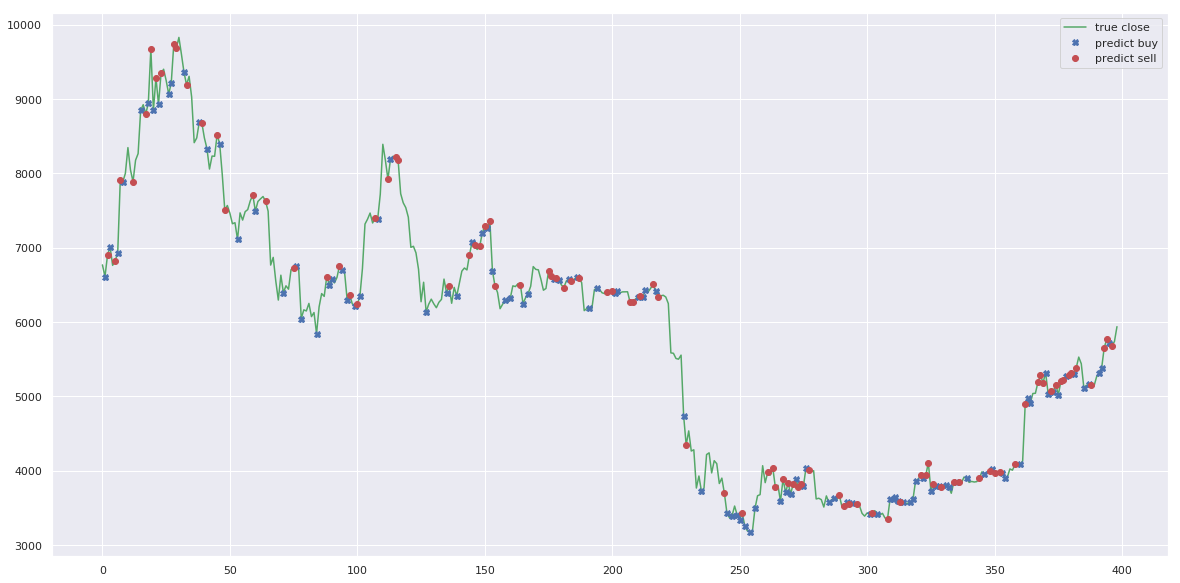

In [37]:
model = Model(input_size = 30, 
              layer_size = 500, 
              output_size = 3)
agent = Agent(population_size = 15, 
              sigma = 0.1, 
              learning_rate = 0.03, 
              model = model, 
              money = 10000, 
              max_buy = 5, 
              max_sell = 5, 
              skip = 1, 
              window_size = 30)
agent.fit(500, 100)
agent.buy()

#### bayesian parameters

iter 100. reward: 757.100000
iter 200. reward: 919.405000
iter 300. reward: 1018.565000
iter 400. reward: 1069.455000
iter 500. reward: 1138.220000
time taken to train: 139.9797899723053 seconds
day 0: buy 5 units at price 33847.500000, total balance -23847.500000
day 2, sell 5 units at price 34502.500000, investment 1.935150 %, total balance 10655.000000,
day 4: buy 5 units at price 33815.000000, total balance -23160.000000
day 10, sell 5 units at price 41732.500000, investment 23.414165 %, total balance 18572.500000,
day 12: buy 5 units at price 39447.500000, total balance -20875.000000
day 16, sell 5 units at price 44617.500000, investment 13.106027 %, total balance 23742.500000,
day 18: buy 5 units at price 44715.000000, total balance -20972.500000
day 24, sell 5 units at price 47002.500000, investment 5.115733 %, total balance 26030.000000,
day 26: buy 5 units at price 45330.000000, total balance -19300.000000
day 30, sell 5 units at price 49142.500000, investment 8.410545 %, tota

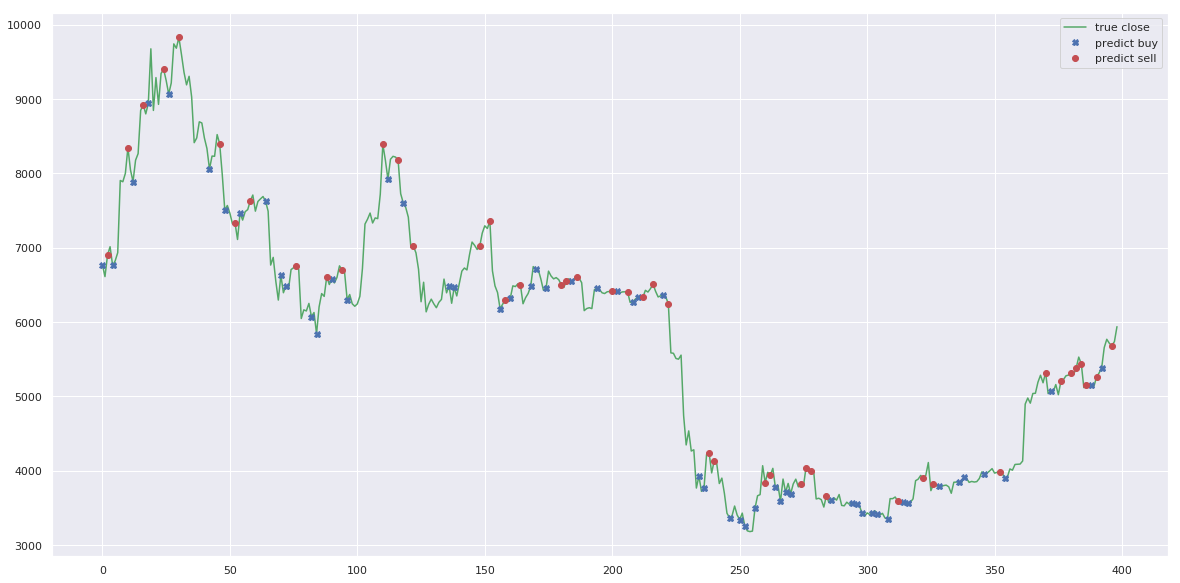

In [38]:
model = Model(input_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['window_size'])), 
              layer_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['size_network'])), 
              output_size = 3)
agent = Agent(population_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['population_size'])), 
              sigma = NN_BAYESIAN.res['max']['max_params']['sigma'], 
              learning_rate = NN_BAYESIAN.res['max']['max_params']['learning_rate'], 
              model = model, 
              money = 10000, 
              max_buy = 5, 
              max_sell = 5, 
              skip = int(np.around(NN_BAYESIAN.res['max']['max_params']['skip'])), 
              window_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['window_size'])))
agent.fit(500, 100)
agent.buy()